In [67]:
!pip install bertopic==0.16.4
!pip install sastrawi
!pip install nltk
!pip install contractions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [68]:
import re
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [69]:
df = pd.read_excel('/kaggle/input/database-laporan/Database.new.xlsx')
df.head()

,Incident Number,Closure Product Name,Summary,Notes
0,INC000000243446,APOLO Perbankan,Subject: Re: Bukti Kirim Absensi Laporan Insid...,bpr.umida@yahoo.co.id*7:03*\n\nFrom: Bpr Umida...
1,INC000000243450,APOLO Perbankan,Subject: Re: FW: Tidak Berhasil Validasi,bankardakediri@gmail.com*07:11*\n\nFrom: BANK ...
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...
3,INC000000243456,APOLO Pasar Modal,Subject: Kesalahan pada aplikasi AR Apolo,kaphse.hendro@gmail.com*7:31*\n\nFrom: hendro ...
4,INC000000243458,APOLO Perbankan,Subject: RE: Permohonan Lupa Password APOLO,rizkia@nexia.id*7:33*\n\nFrom: Rizkia Nurul Ha...


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8051 entries, 0 to 8050
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Incident Number       8051 non-null   object
 1   Closure Product Name  8051 non-null   object
 2   Summary               8051 non-null   object
 3   Notes                 8051 non-null   object
dtypes: object(4)
memory usage: 251.7+ KB


In [71]:
def extract_complaint(text):
    if not isinstance(text, str):
        return "Bagian komplain tidak ditemukan."

    start_patterns = [
    r"(?i)perhatian:\s*e-?mail ini berasal dari pihak di luar OJK\.?\s*harap waspada ketika akan membuka lampiran.*?tautan.*?e-?mail ini\.?",
    r"(?i)peringatan\s*:?\s*e-?mail ini mengandung URL tidak dikenal dan berpotensi bahaya\.?\s*jangan membuka URL tersebut, kecuali Anda yakin dengan isinya\.?"
]


    start_match = None
    for pattern in start_patterns:
        matches = list(re.finditer(pattern, text, re.DOTALL))
        if matches:
            start_match = matches[-1].end()

    if start_match:
        text = text[start_match:].strip()

    end_patterns = [
        r"(?i)best regards",
        r"(?i)warm regards",
        r"(?i)regards",
        r"(?i)hormat kami",
        r"(?i)salam hormat",
        r"(?i)demikian.*",
        r"(?i)from: .*",
        r"(?i)call center",
        r"(?i)visit our website",
    ]

    for pattern in end_patterns:
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = text[:match.start()]
            break

    # Cleaning sensitive/personal content
    sensitive_info_patterns = [
        r"(?i)Nama\s*Perusahaan\s*.*",
        r"(?i)Nama\s*Pelapor\s*.*",
        r"(?i)Nama\s*BPR\s*.*",
        r"(?i)No\.\s*Surat\s*.*",
        r"(?i)Nama\s*Bank\s*.*",
        r"(?i)Nama\s*KAP\s*.*",
        r"(?i)NPWP\s*Perusahaan\s*.*",
        r"(?i)Nama\s*File\s*.*",
        r"(?i)No\.\s*Telp\s*.*",
        r"(?i)No\.\s*Telp\s*Pelapor\s*.*",
        r"(?i)Nama\s*Terdaftar\s*.*",
        # r"(?i)Email\s*.*",
        # r"(?i)User\s*Id\s*/\s*User\s*Name\s*.*",
        # r"(?i)No\.\s*KTP\s*.*",
        # r"(?i)Internal",
        # r"(?i)Dengan\s*hormat.*",
        # r"(?i)Jenis\s*Usaha\s*.*",
        # r"(?i)Keterangan\s*.*",
        # r"(?i)Alamat\s*website/URL\s*.*",
        # r"(?i)Selamat\s*(Pagi|Siang|Sore).*",
        # r"(?i)Kepada\s*Yth\.\s*Bapak/Ibu.*",
        # r"(?i)On\s*full_days\s*\d+\d+,\s*\d{4}-\d{2}-\d{2}\s*at\s*\d{2}:\d{2}.*",
        # r"(?i)Dear\s*Bapak/Ibu\s*Helpdesk\s*OJK.*",
        # r"(?i)No\.\s*NPWP\s*Perusahaan\s*.*",
        # r"(?i)Aplikasi\s*OJK\s*yang\s*di\s*akses\s*.*",
        # r"(?i)Yth\s*.*",
        # r"(?i)Demikian\s*.*",
        # r"(?i)Demikianlah\s*.*",
    ]

    for pattern in sensitive_info_patterns:
        text = re.sub(pattern, "", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text if text else "Bagian komplain tidak ditemukan."

In [72]:
def clean_email_text(text):
    keywords = [
        "terlampir", "mohon bantuan", "terima kasih", "yth", "assalamualaikum", "wabarakatuh", "warahmatullahi",
        "dear", "salam hormat", "selamat", "pagi", "siang", "berikut", "no2", "BaI", "rl008", "atas bantuan",
        "sore", "malam", "kepada", "direktur", "pelaporan data", "departemen", "apoloojkgoid", "semoga", "atas kendala",
        "pengelolaan data", "dan statistik", "menara radius prawiro", "lantai 14", "wassalamu", "alaikum", "hormat",
        "komplek perkantoran", "bank indonesia", "jl", "mh thamrin", "jakarta pusat", "no2", "10350", "sampaikan",
        "Helpdesk", "OJK", "Otoritas Jasa Keuangan", "laporan", "apolo", "terimakasih", "mohon", "apollo",
        "hari", "senin", "selasa", "rabu", "kamis", "jumat", "sabtu", "minggu", "2024", "2025", "https", "assalamu", "alaikum",
        "bpr", "bank", "perusahaan", "perkenalkan", "team", "bersama", "aplikasi", "regards", "responsible", "perhatian", "ucapkan", "confidential", "url", "website"# "email", "akses" , 
    ]

    pattern = r"(?i)(" + "|".join(re.escape(k) for k in keywords) + r")"

    text = re.sub(pattern, "", text)

    return text

In [73]:
def remove_emails(text):
    email_pattern = r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b"
    text = re.sub(email_pattern, "", text, flags=re.IGNORECASE)
    return text

In [74]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    stopword_factory = StopWordRemoverFactory()
    sastrawi_stop = set(stopword_factory.get_stop_words())
    nltk_stop = set(nltk_stopwords.words("english"))

    combined_stopwords = sastrawi_stop | nltk_stop
    custom_keep = {"tidak", "belum", "bisa", "akses", "login", "ada", "error", "gagal"}
    final_stopwords = combined_stopwords - custom_keep

    words = [w for w in text.split() if w not in final_stopwords and len(w) > 2]

    return ' '.join(words)

In [75]:
def remove_punctuation(text):
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [76]:
def remove_phone_numbers(text):
    phone_pattern = r"(?i)\b(\+62|62|0)?[-.\s]?(\d{2,4}[-.\s]?){2,4}\d{2,4}\b"
    text = re.sub(phone_pattern, "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[0-9]+", "", text)
    
    return text

In [77]:
df['Complaint'] = df.apply(lambda row: extract_complaint(row['Notes']), axis=1)
df['Complaint'] = df['Complaint'].apply(clean_email_text)
df['Complaint'] = df['Complaint'].apply(remove_emails)
df['Complaint'] = df['Complaint'].apply(clean_text)
df['Cleaned_Complaint'] = df['Complaint'].apply(remove_punctuation)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].apply(remove_phone_numbers)

In [78]:
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bmasuk\b", "login", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\blog-in\b", "login", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\brenbis\b", "rencana bisnis", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bapkap\b", "ap kap", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\baro\b", "administrator responsible officer", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bro\b", "responsible officer", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bmengunduh\b", "download", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bunduh\b", "download", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bcondense\b", "condensed", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\blap0ran\b", "laporan", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bsandi\b", "password", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\bisidental\b", "insidental", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.replace(r"(?i)\surat elektronik\b", "email", regex=True)
df['Cleaned_Complaint'] = df['Cleaned_Complaint'].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()

In [79]:
product_map = {
    'APOLO IKNB': 1,
    'APOLO Pasar Modal': 2,
    'APOLO Perbankan': 3,
    'ARIA': 4,
    'E-Reporting PM dan IKNB': 5,
    'Pusdafil': 6,
    'SILARAS': 7,
    'SILKM': 8,
    'SIPEDULI': 9,
    'SiPINA': 10,
    'SLIK': 11
}

grouped = df.groupby('Closure Product Name')

for name, group in grouped:
    group_number = product_map.get(name, None)
    if group_number is not None:
        globals()[f"df_{group_number}"] = group

In [80]:
for i in range(1, 12):
    df_name = globals().get(f"df_{i}")
    if df_name is not None:
        print(f"Jumlah data untuk df_{i}: {len(df_name)}")

Jumlah data untuk df_1: 1057
Jumlah data untuk df_2: 384
Jumlah data untuk df_3: 2009
Jumlah data untuk df_4: 101
Jumlah data untuk df_5: 878
Jumlah data untuk df_6: 62
Jumlah data untuk df_7: 167
Jumlah data untuk df_8: 11
Jumlah data untuk df_9: 893
Jumlah data untuk df_10: 165
Jumlah data untuk df_11: 2322


In [81]:
df_1['no_contractions'] = df_1['Cleaned_Complaint'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ..."
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,..."
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,..."
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k..."
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ..."


In [82]:
df_1['reviews_no_contractions'] = [' '.join(l) for l in df_1['no_contractions']]
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...


In [83]:
df_1['reviews_tokenized'] = df_1['reviews_no_contractions'].apply(word_tokenize)
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ..."
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,..."
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,..."
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k..."
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ..."


In [84]:
df_1['reviews_cleaned'] = [' '.join(l) for l in df_1['reviews_tokenized']]
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...


In [85]:
df_1['reviews_tokenized'] = df_1['reviews_cleaned'].apply(word_tokenize)
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...


In [86]:
df_1['reviews_pos_tags'] = df_1['reviews_tokenized'].apply(nltk.tag.pos_tag)
df_1.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned,reviews_pos_tags
2,INC000000243453,APOLO IKNB,Subject: Re: FW: Pengiriman laporan gagal kare...,ahmad.mauladi@lescagadai.co.id*7:23*\n\nFrom: ...,nama ahmad mauladi lesca gadai premier mau kir...,nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...,"[nama, ahmad, mauladi, lesca, gadai, premier, ...",nama ahmad mauladi lesca gadai premier mau kir...,"[(nama, RB), (ahmad, JJ), (mauladi, NN), (lesc..."
5,INC000000243614,APOLO IKNB,Subject: [PT Asuransi Allianz Utama Indonesia]...,rizky.aditya@allianz.co.id*10:39*\nFrom: Adity...,internal email user user name terdaftar ktp np...,internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...,"[internal, email, user, user, name, terdaftar,...",internal email user user name terdaftar ktp np...,"[(internal, JJ), (email, NN), (user, NN), (use..."
14,INC000000243547,APOLO IKNB,Subject: RE: Industrial Test Laporan Penunjuka...,firda.hardiyanti@tokiomarine-life.co.id*10.06*...,bapak ibu pic menginformasikan melakukan indus...,bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...,"[bapak, ibu, pic, menginformasikan, melakukan,...",bapak ibu pic menginformasikan melakukan indus...,"[(bapak, NN), (ibu, NN), (pic, NN), (menginfor..."
21,INC000000243580,APOLO IKNB,Subject: REMINDER: ERROR Aplikasi Client PKAP ...,sheldani.daniesha@bina-artha.co.id*10:30*\nFro...,pic penjelasannya client penunjukan apkap bina...,pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...,"[pic, penjelasannya, client, penunjukan, ap, k...",pic penjelasannya client penunjukan ap kap bin...,"[(pic, NN), (penjelasannya, NN), (client, NN),..."
22,INC000000243594,APOLO IKNB,Subject: RE: KIRIM ULANG : permohonan petunjuk...,finance@hanoferre.co.id* 11:07*\nFrom: finance...,sent desember administrator imam lisfar subjec...,sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...,"[sent, desember, administrator, imam, lisfar, ...",sent desember administrator imam lisfar subjec...,"[(sent, JJ), (desember, NN), (administrator, N..."


In [87]:
df_1['reviews_adjectives'] = df_1['reviews_pos_tags'].apply(lambda x: [word for (word, pos_tag) in x if 'JJ' in (word, pos_tag)])

In [88]:
def combine_words(word_list):    
    all_words = []
    for word in word_list:
        all_words += word
    return all_words

In [89]:
def count_topwords(all_words):
    counts = dict()
    for word in all_words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    word_count = pd.DataFrame([counts])
    word_count_transposed = word_count.T.reset_index()
    word_count_transposed.columns = ['words','word_count']
    word_count_sorted = word_count_transposed.sort_values("word_count",ascending = False)
    word_count_sorted
    return word_count_sorted[:20]

In [90]:
reviews = df_1['reviews_adjectives']
reviews_words =  combine_words(reviews)
reviews_words[:10]

['ahmad',
 'keterangannya',
 'terkirim',
 'nya',
 'nya',
 'internal',
 'npwp',
 'usaha',
 'umum',
 'hak']

In [91]:
reviews_topword_count = count_topwords(reviews_words)
reviews_topword_count.head()

,words,word_count
9,responsible,542
16,tanggal,317
3,nya,257
47,penyampaian,247
56,sehubungan,205


<Axes: xlabel='words', ylabel='word_count'>

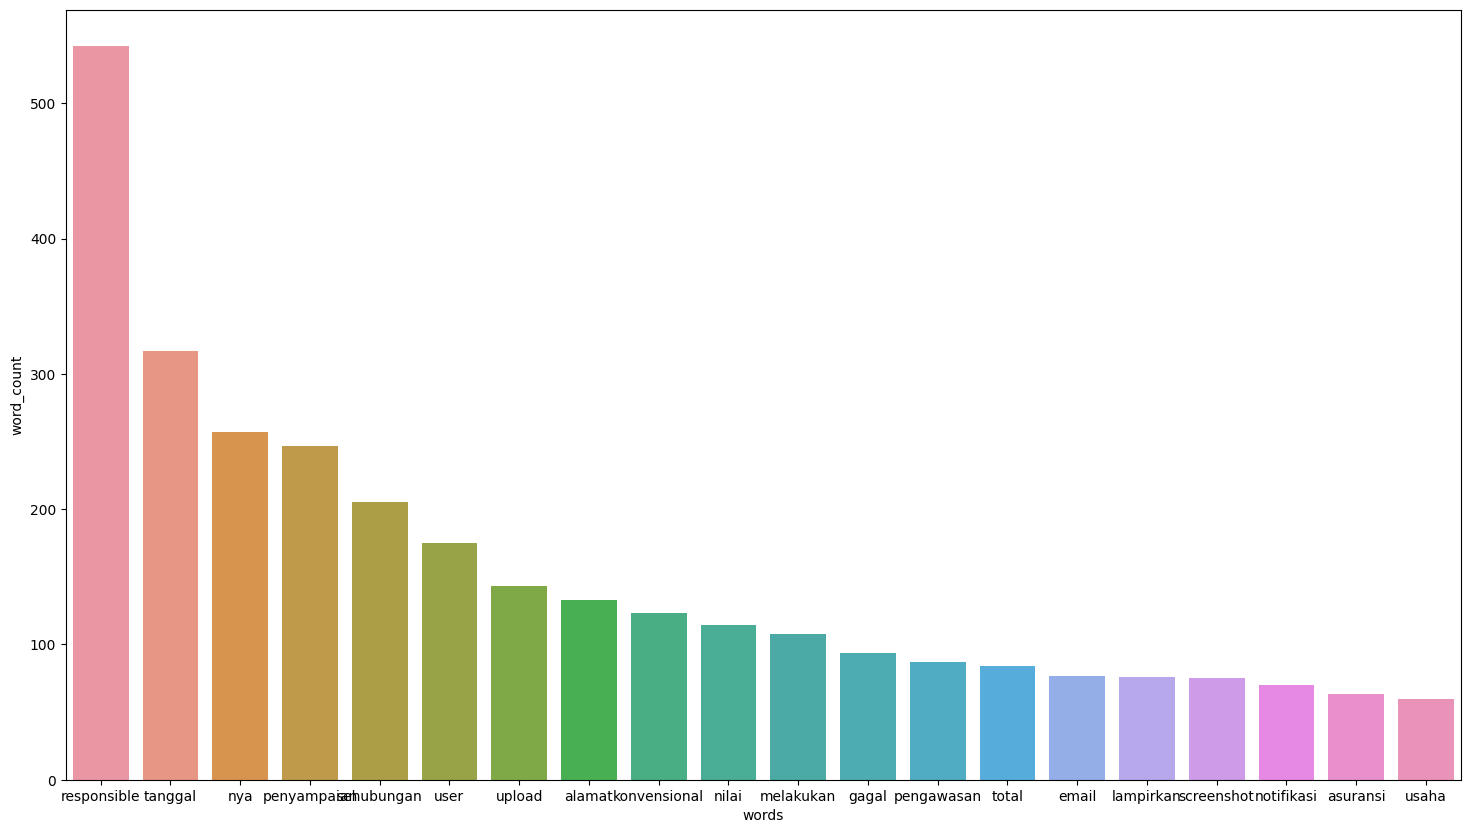

In [92]:
plt.figure(figsize= (18,10))

sns.barplot(data = reviews_topword_count ,x= reviews_topword_count['words'], y= reviews_topword_count['word_count'] )

In [93]:
umap_model = UMAP(
    n_neighbors=5,
    n_components=1,
    min_dist=0.00,
    metric='cosine',
    low_memory=False,
    random_state=1337
)

hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

topic_model1 = BERTopic(
    language="indonesian",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True
)

In [94]:
words_to_remove = r"\b(responsible|perhatian|ucapkan|confidential|url|website|bapak|ibu|putu|dian|kristina|murti|indra|hungan|ykh|bpk|bhakti|sumekar|perseroda|hungi|pasarraya|kuta|dihungi|bnp|paribas|dewan|komisioner)\b"

df_1['Cleaned_Complaint'] = df_1['Cleaned_Complaint'].str.replace(words_to_remove, '', regex=True)
df_1['Cleaned_Complaint'] = df_1['Cleaned_Complaint'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [95]:
topics, probs = topic_model1.fit_transform(df_1['Cleaned_Complaint'])

df_1['Topic'] = topics
df_1['Topic_Probability'] = probs.max(axis=1)

topic_model1.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,102,-1_anti_fraud_strategi_tersebut,"[anti, fraud, strategi, tersebut, polis, offic...",[detail permasalahannya sehubungan informasi i...
1,0,386,0_data_kendala_tidak_validasi,"[data, kendala, tidak, validasi, baris, polis,...",[email diakses asrjs client self assessment tk...
2,1,214,1_administrator_officer_peran_akses,"[administrator, officer, peran, akses, rencana...",[internal email user user name terdaftar ktp n...
3,2,90,2_email_tidak_kendala_diakses,"[email, tidak, kendala, diakses, alamat, atas,...",[informasi diminta email sebelumnya email tlp ...
4,3,83,3_password_login_email_tidak,"[password, login, email, tidak, akun, username...",[tim email akses alamat diakses account login ...
5,4,76,4_elektronik_surat_asuransi_virus,"[elektronik, surat, asuransi, virus, email, pe...",[pic penjelasannya client penunjukan ap kap bi...
6,5,55,5_email_alamat_client_download,"[email, alamat, client, download, diakses, kap...",[mengalami kendala mencoba download client tan...
7,6,51,6_fraud_anti_strategi_penerapan,"[fraud, anti, strategi, penerapan, terkait, ma...",[terkait strategi anti fraud perlu client tida...


In [96]:
topic_visualize = topic_model1.visualize_topics()
topic_visualize

In [97]:
df_1.to_excel("apoloiknb.xlsx", index=False)

In [98]:
df_5['no_contractions'] = df_5['Cleaned_Complaint'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen..."
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,..."
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,..."
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,..."
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh..."


In [99]:
df_5['reviews_no_contractions'] = [' '.join(l) for l in df_5['no_contractions']]
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...


In [100]:
df_5['reviews_tokenized'] = df_5['reviews_no_contractions'].apply(word_tokenize)
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen..."
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,..."
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,..."
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,..."
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh..."


In [101]:
df_5['reviews_cleaned'] = [' '.join(l) for l in df_5['reviews_tokenized']]
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...


In [102]:
df_5['reviews_tokenized'] = df_5['reviews_cleaned'].apply(word_tokenize)
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...


In [103]:
df_5['reviews_pos_tags'] = df_5['reviews_tokenized'].apply(nltk.tag.pos_tag)
df_5.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned,reviews_pos_tags
10,INC000000243486,E-Reporting PM dan IKNB,Subject: Kendala Penginputan pada E-Reporting,adm.lansmuliagadaibali@gmail.com*08.47*\n\nFro...,bapak ibu nya terkait kendala alami penginputa...,bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...,"[bapak, ibu, nya, terkait, kendala, alami, pen...",bapak ibu nya terkait kendala alami penginputa...,"[(bapak, NN), (ibu, NN), (nya, JJ), (terkait, ..."
100,INC000000243851,E-Reporting PM dan IKNB,Subject: Re: FW: tidak bisa log in e reporting,ptgadaisumberrejeki@gmail.com*10:02*\n\nFrom: ...,pak cek terkait email reporting kendala nya ap...,pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...,"[pak, cek, terkait, email, reporting, kendala,...",pak cek terkait email reporting kendala nya ap...,"[(pak, NN), (cek, NN), (terkait, NN), (email, ..."
263,INC000000244399,E-Reporting PM dan IKNB,Subject: Re: Pertanyaan Mengenai Alur Penyampa...,bogor@fastvalue.co.id*15.39*\n\nFrom: Kantor C...,tim tiara kjpp firman suryantoro sugeng suzy h...,tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...,"[tim, tiara, kjpp, firman, suryantoro, sugeng,...",tim tiara kjpp firman suryantoro sugeng suzy h...,"[(tim, NN), (tiara, NN), (kjpp, NN), (firman, ..."
314,INC000000244593,E-Reporting PM dan IKNB,Subject: Re: Laporan Rencana Bisnis PT Ciptada...,nurhayatikeisha@ciptadana.com*9:15*\n\nFrom: K...,layanan terkait kewajiban rencana bisnis tahun...,layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...,"[layanan, terkait, kewajiban, rencana, bisnis,...",layanan terkait kewajiban rencana bisnis tahun...,"[(layanan, JJ), (terkait, NN), (kewajiban, NN)..."
325,INC000000244659,E-Reporting PM dan IKNB,Subject: Re: Izin Buka Akses Ereporting,gadaistartech57@gmail.com* 09:59*\nFrom: Start...,izin soni gunarso startech gadai hastadharana ...,izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...,"[izin, soni, gunarso, startech, gadai, hastadh...",izin soni gunarso startech gadai hastadharana ...,"[(izin, NN), (soni, NN), (gunarso, NN), (start..."


In [104]:
df_5['reviews_adjectives'] = df_5['reviews_pos_tags'].apply(lambda x: [word for (word, pos_tag) in x if 'JJ' in (word, pos_tag)])

In [105]:
reviews = df_5['reviews_adjectives']
reviews_words =  combine_words(reviews)
reviews_words[:10]

['nya',
 'upload',
 'alamat',
 'nya',
 'sugeng',
 'rekan',
 'penyampaian',
 'penyampaian',
 'iknb',
 'online']

In [106]:
reviews_topword_count = count_topwords(reviews_words)
reviews_topword_count.head()

,words,word_count
5,penyampaian,372
1,upload,274
47,sehubungan,240
0,nya,216
64,tanggal,178


<Axes: xlabel='words', ylabel='word_count'>

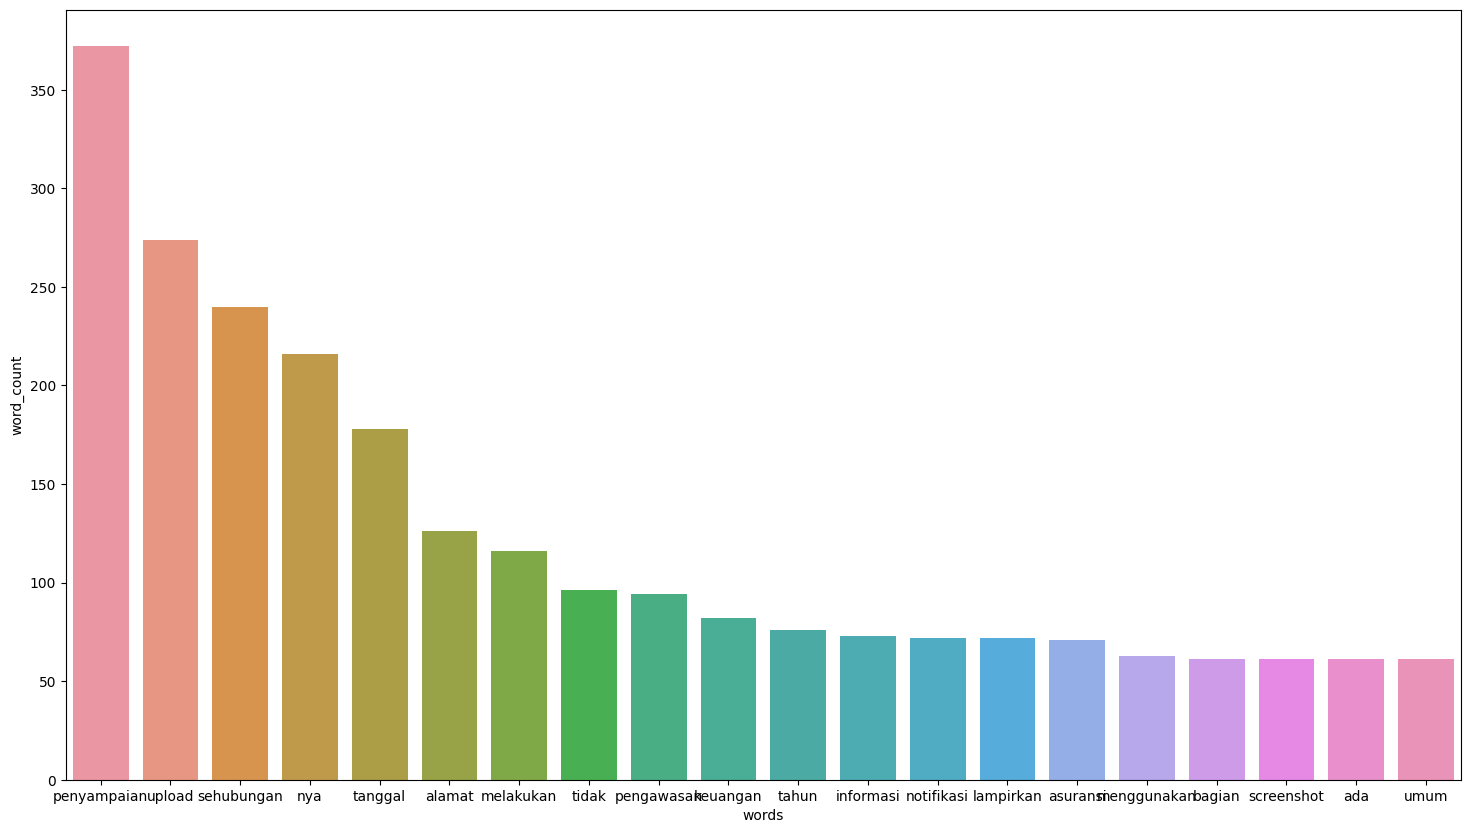

In [107]:
plt.figure(figsize= (18,10))

sns.barplot(data = reviews_topword_count ,x= reviews_topword_count['words'], y= reviews_topword_count['word_count'] )

In [108]:
umap_model = UMAP(
    n_neighbors=5,
    n_components=1,
    min_dist=0.00,
    metric='cosine',
    low_memory=False,
    random_state=1337
)

hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

topic_model5 = BERTopic(
    language="indonesian",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True
)

In [109]:
words_to_remove = r"\b(reporting|ereporting|tanggal|nya|responsible|perhatian|ucapkan|confidential|url|website|bapak|ibu|putu|dian|kristina|murti|indra|hungan|ykh|bpk|bhakti|sumekar|perseroda|hungi|pasarraya|kuta|dihungi|bnp|paribas|dewan|komisioner)\b"

df_5['Cleaned_Complaint'] = df_5['Cleaned_Complaint'].str.replace(words_to_remove, '', regex=True)
df_5['Cleaned_Complaint'] = df_5['Cleaned_Complaint'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [110]:
topics, probs = topic_model5.fit_transform(df_5['Cleaned_Complaint'])

df_5['Topic'] = topics
df_5['Topic_Probability'] = probs.max(axis=1)

topic_model5.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,90,-1_information_email_mail_use,"[information, email, mail, use, recipient, int...",[bagian pengawas kirimkan bulan maret revisi s...
1,0,198,0_template_terbaru_tidak_download,"[template, terbaru, tidak, download, menggunak...",[info kendala atas semester tahun sbb penilaia...
2,1,188,1_keuangan_email_atas_asuransi,"[keuangan, email, atas, asuransi, kendala, mel...",[pic sistem pic direktorat tempat email akses ...
3,2,84,2_email_password_alamat_tidak,"[email, password, alamat, tidak, diakses, akse...",[data email akses alamat diakses tidak bisa me...
4,3,79,3_bisnis_rencana_tim_tahun,"[bisnis, rencana, tim, tahun, atas, akses, ema...",[yoannes paulus diva rahmaini pertanyaan terka...
5,4,67,4_registrasi_akses_melakukan_tidak,"[registrasi, akses, melakukan, tidak, www, ken...",[tim help desk peran pembukaan akses www uploa...
6,5,66,5_kendala_subject_tersebut_terkait,"[kendala, subject, tersebut, terkait, akses, s...",[pengawasan industri keuangan non sehubungan k...
7,6,55,6_kendala_sistem_email_template,"[kendala, sistem, email, template, tersebut, p...",[direktorat sehubungan adanya kendala proses p...
8,7,51,7_psak_run_parallel_keuangan,"[psak, run, parallel, keuangan, asuransi, peri...",[help desk gedung wisma mulia jalan jenderal g...


In [111]:
topic_visualize = topic_model5.visualize_topics()
topic_visualize

In [112]:
df_5.to_excel("erepbaru.xlsx", index=False)

In [113]:
df_11['no_contractions'] = df_11['Cleaned_Complaint'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi..."
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia..."
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se..."
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ..."
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[]


In [114]:
df_11['reviews_no_contractions'] = [' '.join(l) for l in df_11['no_contractions']]
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[],


In [115]:
df_11['reviews_tokenized'] = df_11['reviews_no_contractions'].apply(word_tokenize)
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi..."
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia..."
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se..."
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ..."
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[],,[]


In [116]:
df_11['reviews_cleaned'] = [' '.join(l) for l in df_11['reviews_tokenized']]
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[],,[],


In [117]:
df_11['reviews_tokenized'] = df_11['reviews_cleaned'].apply(word_tokenize)
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[],,[],


In [118]:
df_11['reviews_pos_tags'] = df_11['reviews_tokenized'].apply(nltk.tag.pos_tag)
df_11.head()

,Incident Number,Closure Product Name,Summary,Notes,Complaint,Cleaned_Complaint,no_contractions,reviews_no_contractions,reviews_tokenized,reviews_cleaned,reviews_pos_tags
16,INC000000243564,SLIK,[TIKET CB] INSTALL IDEB VIEWER SLIK (DPIA-NB24...,"Selamat Siang,\nKepada Tim FLS Aplikasi,\nPerm...",tim fls permasalahan bawah diadministrasikan n...,tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...,"[tim, fls, permasalahan, bawah, diadministrasi...",tim fls permasalahan bawah diadministrasikan n...,"[(tim, NN), (fls, NN), (permasalahan, NN), (ba..."
17,INC000000243570,SLIK,Subject: Kendala Pelaporan SLIK,anggrieta08@gmail.com*10:05*\nFrom: ANGGRIETA ...,bapak ibu tempat email 085722657030 akses alam...,bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...,"[bapak, ibu, tempat, email, akses, alamat, dia...",bapak ibu tempat email akses alamat diakses sl...,"[(bapak, NN), (ibu, NN), (tempat, NN), (email,..."
20,INC000000243578,SLIK,Subject: Re: Tidak Bisa Log In Akun SLIK,nbp11cianjur@gmail.com*10:23*\nFrom: BPR NBP 1...,pekernalkankami nusantara bona pasogit sebelas...,pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...,"[pekernalkankami, nusantara, bona, pasogit, se...",pekernalkankami nusantara bona pasogit sebelas...,"[(pekernalkankami, NN), (nusantara, NN), (bona..."
32,INC000000243617,SLIK,Subject: Re: Mohon arahan terkait pelaporan SL...,reza.pahlevi@cgsi.com* 11:33*\nFrom: Reza Pahl...,classification eksternal sehubungan slik menan...,classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...,"[classification, eksternal, sehubungan, slik, ...",classification eksternal sehubungan slik menan...,"[(classification, NN), (eksternal, JJ), (sehub..."
40,INC000000243636,SLIK,Subject: Konfirmasi user SLIK pegawai di Kanto...,catur.nugroho@ojk.go.id*12:07*\n\nFrom: Catur ...,,,[],,[],,[]


In [119]:
df_11['reviews_adjectives'] = df_11['reviews_pos_tags'].apply(lambda x: [word for (word, pos_tag) in x if 'JJ' in (word, pos_tag)])

In [120]:
reviews = df_11['reviews_adjectives']
reviews_words =  combine_words(reviews)
reviews_words[:10]

['diadministrasikan',
 'sumitro',
 'alamat',
 'slik',
 'lampirkan',
 'dibantu',
 'user',
 'informasi',
 'user',
 'slik']

In [121]:
reviews_topword_count = count_topwords(reviews_words)
reviews_topword_count.head()

,words,word_count
3,slik,1501
6,user,618
15,nya,512
2,alamat,323
106,tanggal,304


<Axes: xlabel='words', ylabel='word_count'>

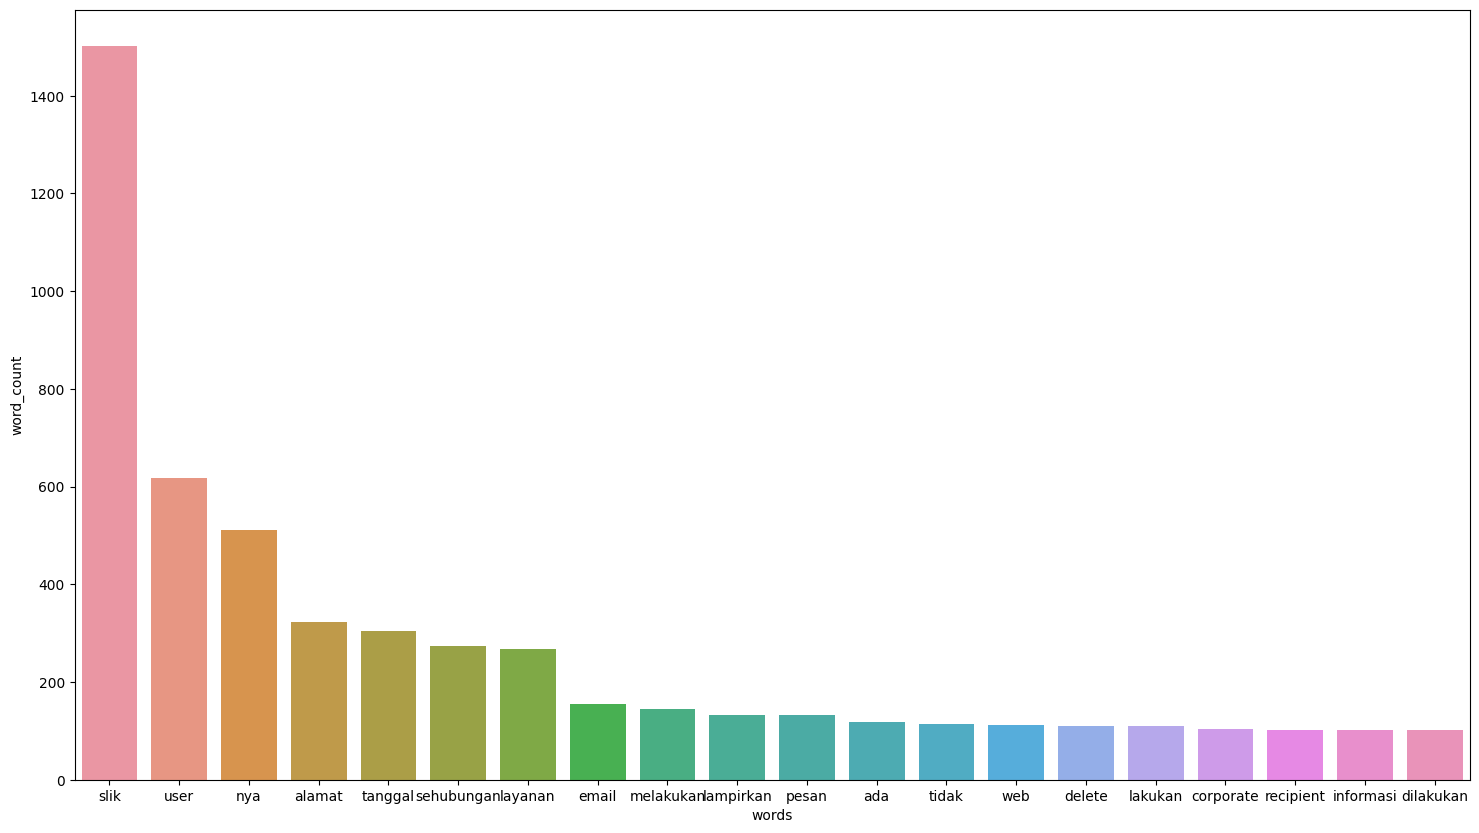

In [122]:
plt.figure(figsize= (18,10))

sns.barplot(data = reviews_topword_count ,x= reviews_topword_count['words'], y= reviews_topword_count['word_count'] )

In [209]:
umap_model = UMAP(
    n_neighbors=7,
    n_components=3,
    min_dist=0.00,
    metric='cosine',
    low_memory=False,
    random_state=1337
)

hdbscan_model = HDBSCAN(
    min_cluster_size=70,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

topic_model11 = BERTopic(
    language="indonesian",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True
)

In [210]:
words_to_remove = r"\b(user|corporate|syariah|ext|slik|nomor|bapak|ibu|putu|dian|kristina|murti|indra|hungan|ykh|bpk|bhakti|sumekar|perseroda|hungi|pasarraya|kuta|dihungi|bnp|paribas|dewan|komisioner)\b"

df_11['Cleaned_Complaint'] = df_11['Cleaned_Complaint'].str.replace(words_to_remove, '', regex=True)
df_11['Cleaned_Complaint'] = df_11['Cleaned_Complaint'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [211]:
topics, probs = topic_model11.fit_transform(df_11['Cleaned_Complaint'])

df_11['Topic'] = topics
df_11['Topic_Probability'] = probs.max(axis=1)

topic_model11.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,531,-1_email_mail_tidak_data,"[email, mail, tidak, data, akses, kendala, web...",[nya riset pass tidak ada login email ria novi...
1,0,784,0_data_debitur_koreksi_atas,"[data, debitur, koreksi, atas, tidak, informas...",[tempat bantu mengenai kendala laporkan sebelu...
2,1,454,1_administrator_login_email_akses,"[administrator, login, email, akses, nya, akun...",[login administrator menonaktifkan ada menamba...
3,2,196,2_email_akses_domain_alamat,"[email, akses, domain, alamat, diakses, surat,...","[email akses alamat diakses, email akses alama..."
4,3,121,3_informasi_peran_akses_surat,"[informasi, peran, akses, surat, kredit, email...",[iii erm grc lampiran perubahan daftar pegawai...
5,4,119,4_password_reset_login_email,"[password, reset, login, email, tidak, nya, lu...",[nya tidak bisa ganti password buka menggunaka...
6,5,117,5_login_tidak_bisa_menit,"[login, tidak, bisa, menit, kendala, sesi, akt...",[perkan permintaan ideb atas nama agus setyono...


In [212]:
topic_visualize = topic_model11.visualize_topics()
topic_visualize

In [213]:
df_11.to_excel("sliklagi.xlsx", index=False)